In [1]:
## importing libraries

import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Flatten, Dropout
from tensorflow.keras.applications.vgg16 import VGG16 as PretrainedModel
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Conv2D, Reshape, Multiply, Add, Activation, Lambda, Concatenate
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from glob import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys, os

from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.metrics import classification_report
import seaborn as sns
import cv2

In [2]:
## loading dataset

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
train_path = "drive/MyDrive/Akhil's Drive /udemy notebooks/CNN_ATTENTION_BLOCK/data/train"
test_path = "drive/MyDrive/Akhil's Drive /udemy notebooks/CNN_ATTENTION_BLOCK/data/test"
IMAGE_SIZE = [224, 224]


### NOTE

# 0 - cercospora
# 1 - common rust
# 2 - healthy
# 3 - northern leaf blight

In [4]:
image_files = glob(train_path + '/*/*.jpg')
valid_image_files = glob(test_path + '/*/*.jpg')

In [5]:
folders = glob(train_path + '/*')
folders

["drive/MyDrive/Akhil's Drive /udemy notebooks/CNN_ATTENTION_BLOCK/data/train/0",
 "drive/MyDrive/Akhil's Drive /udemy notebooks/CNN_ATTENTION_BLOCK/data/train/1",
 "drive/MyDrive/Akhil's Drive /udemy notebooks/CNN_ATTENTION_BLOCK/data/train/2",
 "drive/MyDrive/Akhil's Drive /udemy notebooks/CNN_ATTENTION_BLOCK/data/train/3"]

In [6]:
## loading x_train, y_train, x_test and y_test

def load_dataset(i):
    dataset = []
    labels = []

    path = train_path + '/'+ str(i)
    files = os.listdir(path)
    for file in files:
        file_path = os.path.join(path, file)
        img = cv2.imread(file_path)
        if img is None:
            continue
        img = cv2.resize(img, (224, 224))
        dataset.append(img)
        labels.append(i)
    return np.array(dataset), np.array(labels)

In [7]:
cercospora, cer_label = load_dataset(0)
common_rust, comm_label = load_dataset(1)
healthy, heal_label = load_dataset(2)
northern_leaf_blight, northern_label = load_dataset(3)

In [8]:
X = np.concatenate((cercospora, common_rust, healthy, northern_leaf_blight))
y = np.concatenate((cer_label, comm_label, heal_label, northern_label))
X.shape, y.shape

((7316, 224, 224, 3), (7316,))

In [9]:
def load_dataset(i):
    dataset = []
    labels = []

    path = test_path + '/'+ str(i)
    files = os.listdir(path)
    for file in files:
        file_path = os.path.join(path, file)
        img = cv2.imread(file_path)
        if img is None:
            continue
        img = cv2.resize(img, (224, 224))
        dataset.append(img)
        labels.append(i)
    return np.array(dataset), np.array(labels)

In [10]:
cercospora_t, cer_label_t = load_dataset(0)
common_rust_t, comm_label_t = load_dataset(1)
healthy_t, heal_label_t = load_dataset(2)
northern_leaf_blight_t, northern_label_t = load_dataset(3)

In [11]:
X_test = np.concatenate((cercospora_t, common_rust_t, healthy_t, northern_leaf_blight_t))
y_test = np.concatenate((cer_label_t, comm_label_t, heal_label_t, northern_label_t))
X_test.shape, y_test.shape

((1829, 224, 224, 3), (1829,))

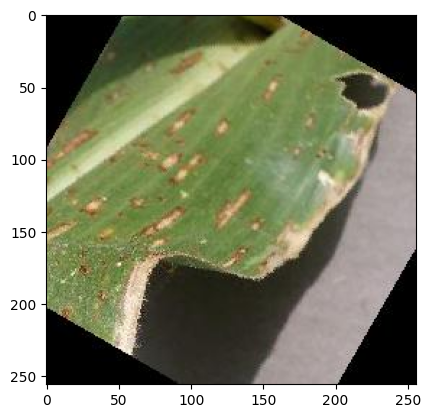

In [12]:
## data sampling and EDA

plt.imshow(image.load_img(image_files[0]))
plt.show()

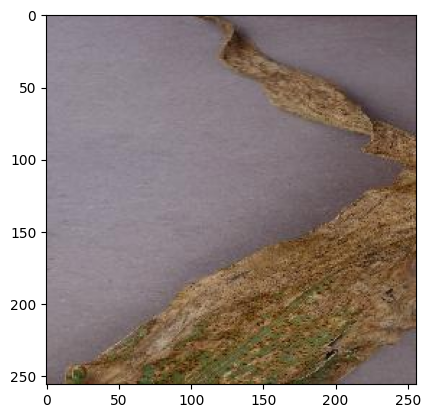

In [13]:
plt.imshow(image.load_img(image_files[-1]))
plt.show()

In [14]:
## base transfer learning CNN defn

ptm = PretrainedModel(
    input_shape=IMAGE_SIZE + [3],
    weights='imagenet',
    include_top=False)

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [16]:
ptm.trainable = False

In [17]:
K = len(folders)

In [ ]:
x = Flatten()(ptm.output)
x = Dropout(0.2)(x)
x = Dense(512, activation='relu')(x)
x = Dense(K, activation='softmax')(x)

In [ ]:
model = Model(inputs=ptm.input, outputs=x)

In [ ]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 27,562,308 (105.14 MB)

 Trainable params: 19,927,044 (76.02 MB)

 Non-trainable params: 7,635,264 (29.13 MB)

In [ ]:
## training TR CNN

model.compile(optimizer = Adam(learning_rate=1e-4),
              loss = 'sparse_categorical_crossentropy',
              metrics = ['accuracy'])

In [ ]:
callbacks = [
    tf.keras.callbacks.ModelCheckpoint("best_model_transfer.keras", save_best_only=True),
    tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)
]

In [ ]:
r = model.fit(X, y, validation_data=(X_test, y_test), epochs=7, callbacks=callbacks)

Epoch 1/7
229/229 ━━━━━━━━━━━━━━━━━━━━ 51s 223ms/step - accuracy: 0.9977 - loss: 0.0097 - val_accuracy: 0.9792 - val_loss: 0.0893
Epoch 2/7
229/229 ━━━━━━━━━━━━━━━━━━━━ 83s 229ms/step - accuracy: 0.9989 - loss: 0.0031 - val_accuracy: 0.9776 - val_loss: 0.0862
Epoch 3/7
229/229 ━━━━━━━━━━━━━━━━━━━━ 81s 223ms/step - accuracy: 0.9996 - loss: 0.0020 - val_accuracy: 0.9803 - val_loss: 0.0875


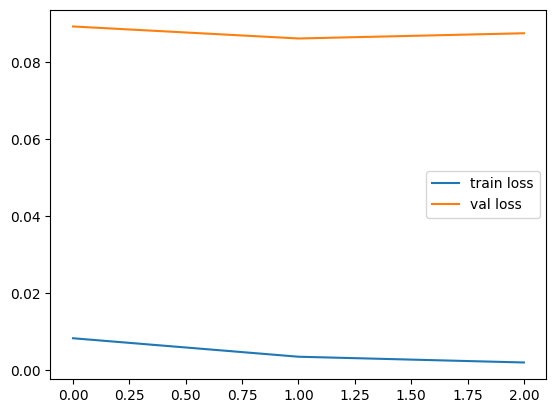

In [ ]:
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='val loss')
plt.legend()
plt.show()

In [ ]:
for layer in ptm.layers[-5:]:
    layer.trainable = True

In [ ]:
model.compile(optimizer = Adam(learning_rate=1e-5),
              loss = 'sparse_categorical_crossentropy',
              metrics = ['accuracy'])

In [ ]:
r2 = model.fit(X, y, validation_data=(X_test, y_test), epochs=10, callbacks=callbacks)

Epoch 1/10
229/229 ━━━━━━━━━━━━━━━━━━━━ 62s 257ms/step - accuracy: 0.9852 - loss: 0.0362 - val_accuracy: 0.9738 - val_loss: 0.0877
Epoch 2/10
229/229 ━━━━━━━━━━━━━━━━━━━━ 78s 247ms/step - accuracy: 0.9951 - loss: 0.0133 - val_accuracy: 0.9776 - val_loss: 0.0744
Epoch 3/10
229/229 ━━━━━━━━━━━━━━━━━━━━ 76s 220ms/step - accuracy: 0.9977 - loss: 0.0075 - val_accuracy: 0.9765 - val_loss: 0.0894
Epoch 4/10
229/229 ━━━━━━━━━━━━━━━━━━━━ 84s 229ms/step - accuracy: 0.9995 - loss: 0.0023 - val_accuracy: 0.9759 - val_loss: 0.0837
Epoch 5/10
229/229 ━━━━━━━━━━━━━━━━━━━━ 80s 220ms/step - accuracy: 0.9997 - loss: 0.0017 - val_accuracy: 0.9787 - val_loss: 0.0958


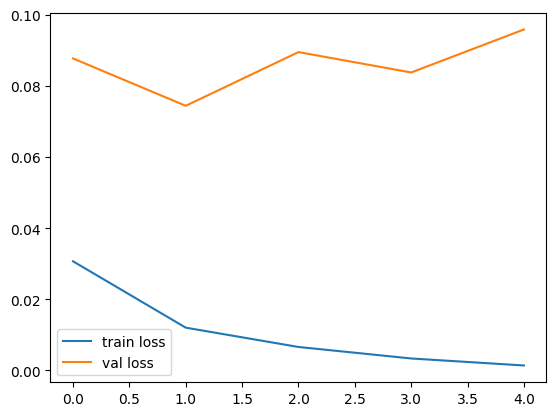

In [ ]:
plt.plot(r2.history['loss'], label='train loss')
plt.plot(r2.history['val_loss'], label='val loss')
plt.legend()
plt.show()

In [ ]:
## model evaluation

model.evaluate(X_test, y_test)

58/58 ━━━━━━━━━━━━━━━━━━━━ 8s 133ms/step - accuracy: 0.9705 - loss: 0.1420


[0.08927599340677261, 0.9792236089706421]

58/58 ━━━━━━━━━━━━━━━━━━━━ 8s 145ms/step


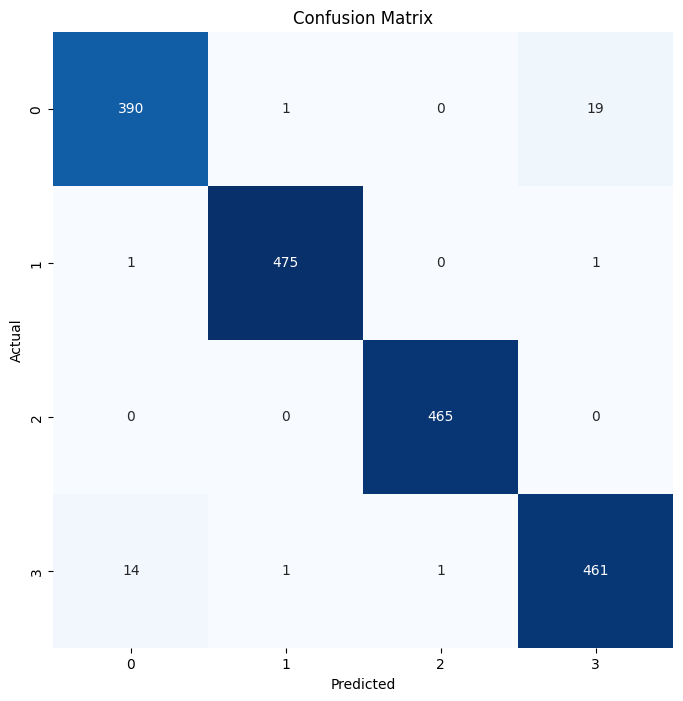

In [ ]:
predictions = np.argmax(model.predict(X_test), axis=-1)
cm = confusion_matrix(y_test, predictions)

plt.figure(figsize=(8, 8))
sns.heatmap(cm, annot=True, fmt='d', vmin=0, cbar=False, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [ ]:

# Generate classification report
class_labels = list(['cercospora', 'common rust', 'healthy', 'northern leaf blight'])
print(classification_report(y_test, predictions, target_names=class_labels))

                      precision    recall  f1-score   support

          cercospora       0.96      0.95      0.96       410
         common rust       1.00      1.00      1.00       477
             healthy       1.00      1.00      1.00       465
northern leaf blight       0.96      0.97      0.96       477

            accuracy                           0.98      1829
           macro avg       0.98      0.98      0.98      1829
        weighted avg       0.98      0.98      0.98      1829



In [18]:
## defining CBAM block
def cbam_block(input_feature, ratio=8):
    """Convolutional Block Attention Module"""
    channel = input_feature.shape[-1]

    # Channel attention
    avg_pool = GlobalAveragePooling2D()(input_feature)
    avg_pool = Reshape((1, 1, channel))(avg_pool)
    assert avg_pool.shape[1:] == (1, 1, channel)

    shared_layer_one = Dense(channel // ratio,
                             activation='relu',
                             kernel_initializer='he_normal',
                             use_bias=True,
                             bias_initializer='zeros')
    shared_layer_two = Dense(channel,
                             kernel_initializer='he_normal',
                             use_bias=True,
                             bias_initializer='zeros')

    avg_pool = shared_layer_one(avg_pool)
    avg_pool = shared_layer_two(avg_pool)

    channel_attention = Activation('sigmoid')(avg_pool)

    # Spatial attention
    avgpool = Lambda(lambda x: tf.reduce_mean(x, axis=3, keepdims=True))(input_feature)
    maxpool = Lambda(lambda x: tf.reduce_max(x, axis=3, keepdims=True))(input_feature)
    spatial = Concatenate()([avgpool, maxpool])

    spatial = Conv2D(filters=1, kernel_size=7, padding='same', activation='sigmoid')(spatial)

    # Multiply
    refined_feature = Multiply()([input_feature, channel_attention])
    refined_feature = Multiply()([refined_feature, spatial])

    return Add()([refined_feature, input_feature])


def create_modified_vgg16(input_shape=(224, 224, 3), num_classes=K):
    base_model = PretrainedModel(weights='imagenet', include_top=False, input_shape=input_shape)

    base_model.trainable = False

    # Get the output of specific layers where we want to add CBAM
    x = base_model.input
    for layer in base_model.layers[1:]:
        x = layer(x, training=False)
        if layer.name in ['block2_conv2', 'block3_conv3', 'block4_conv3']:
            x = cbam_block(x)

    # Add custom head
    x = GlobalAveragePooling2D()(x)
    x = Dense(256, activation='relu')(x)
    x = Dense(64, activation='relu')(x)
    output = Dense(num_classes, activation='softmax')(x)

    # Create the modified model
    model = Model(inputs=base_model.input, outputs=output)

    return model

In [50]:
# Create the model
model = create_modified_vgg16()

In [51]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv1 (Conv2D)     │ (None, 224, 224, 64)   │          1,792 │ input_layer_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv2 (Conv2D)     │ (None, 224, 224, 64)   │         36,928 │ block1_conv1[1][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_pool               │ (None, 112, 112, 64)   │              0 │ block1_conv2[1][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_conv1 (Conv2D)     │ (None, 112, 112, 128)  │         73,856 │ block1_pool[1][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_conv2 (Conv2D)     │ (None, 112, 112, 128)  │        147,584 │ block2_conv1[1][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_average_pooling2d… │ (None, 128)            │              0 │ block2_conv2[1][0]     │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reshape_3 (Reshape)       │ (None, 1, 1, 128)      │              0 │ global_average_poolin… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_9 (Dense)           │ (None, 1, 1, 16)       │          2,064 │ reshape_3[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_10 (Dense)          │ (None, 1, 1, 128)      │          2,176 │ dense_9[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lambda_6 (Lambda)         │ (None, 112, 112, 1)    │              0 │ block2_conv2[1][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lambda_7 (Lambda)         │ (None, 112, 112, 1)    │              0 │ block2_conv2[1][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_3 (Activation) │ (None, 1, 1, 128)      │              0 │ dense_10[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_3             │ (None, 112, 112, 2)    │              0 │ lambda_6[0][0],        │
│ (Concatenate)             │                        │                │ lambda_7[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multiply_6 (Multiply)     │ (None, 112, 112, 128)  │              0 │ block2_conv2[1][0],    │
│                           │                        │                │ activation_3[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 112, 112, 1)    │             99 │ concatenate_3[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multiply_7 (Multiply)     │ (None, 112, 112, 128)  │              0 │ multiply_6[0][0],      │
│                      

 Total params: 14,950,045 (57.03 MB)

 Trainable params: 235,357 (919.36 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [52]:
for layer in model.layers:
    if isinstance(layer, tf.keras.Model):
        for base_layer in layer.layers:
            base_layer.trainable = False

In [53]:
# Make sure the CBAM blocks and dense layers are trainable
for layer in model.layers:
    if 'cbam' in layer.name or isinstance(layer, Dense):
        layer.trainable = True

In [56]:
callbacks = [
    tf.keras.callbacks.ModelCheckpoint("best_model.keras", save_best_only=True),
    tf.keras.callbacks.EarlyStopping(patience=7, restore_best_weights=True)
]

In [55]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(X, y, validation_data=(X_test, y_test), epochs=12, callbacks=callbacks)

Epoch 1/12
229/229 ━━━━━━━━━━━━━━━━━━━━ 95s 373ms/step - accuracy: 0.6470 - loss: 1.9519 - val_accuracy: 0.9284 - val_loss: 0.1920
Epoch 2/12
229/229 ━━━━━━━━━━━━━━━━━━━━ 125s 318ms/step - accuracy: 0.9442 - loss: 0.1580 - val_accuracy: 0.9502 - val_loss: 0.1315
Epoch 3/12
229/229 ━━━━━━━━━━━━━━━━━━━━ 80s 309ms/step - accuracy: 0.9658 - loss: 0.0933 - val_accuracy: 0.9612 - val_loss: 0.1109
Epoch 4/12
229/229 ━━━━━━━━━━━━━━━━━━━━ 84s 320ms/step - accuracy: 0.9805 - loss: 0.0692 - val_accuracy: 0.9568 - val_loss: 0.1140
Epoch 5/12
229/229 ━━━━━━━━━━━━━━━━━━━━ 75s 328ms/step - accuracy: 0.9799 - loss: 0.0528 - val_accuracy: 0.9656 - val_loss: 0.0934
Epoch 6/12
229/229 ━━━━━━━━━━━━━━━━━━━━ 79s 316ms/step - accuracy: 0.9895 - loss: 0.0371 - val_accuracy: 0.9672 - val_loss: 0.0846
Epoch 7/12
229/229 ━━━━━━━━━━━━━━━━━━━━ 83s 320ms/step - accuracy: 0.9938 - loss: 0.0278 - val_accuracy: 0.9656 - val_loss: 0.0845
Epoch 8/12
229/229 ━━━━━━━━━━━━━━━━━━━━ 76s 330ms/step - accuracy: 0.9932 - loss: 

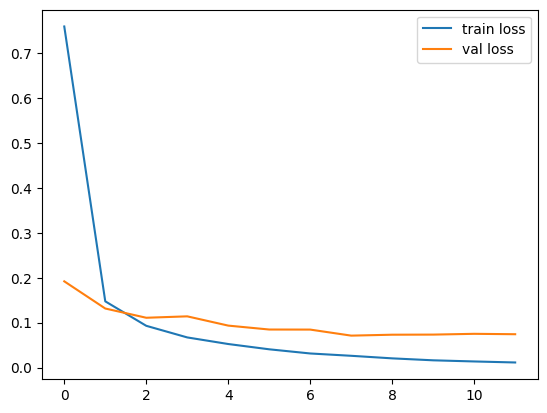

In [57]:
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.legend()
plt.show()

In [58]:
for layer in model.layers[-53:]:
    layer.trainable = True

# Recompile the model with a lower learning rate
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Continue training
history = model.fit(X, y, validation_data=(X_test, y_test), epochs=7, callbacks=callbacks)

Epoch 1/7
229/229 ━━━━━━━━━━━━━━━━━━━━ 108s 429ms/step - accuracy: 0.9801 - loss: 0.0523 - val_accuracy: 0.9781 - val_loss: 0.0615
Epoch 2/7
229/229 ━━━━━━━━━━━━━━━━━━━━ 132s 403ms/step - accuracy: 0.9922 - loss: 0.0192 - val_accuracy: 0.9798 - val_loss: 0.0618
Epoch 3/7
229/229 ━━━━━━━━━━━━━━━━━━━━ 143s 408ms/step - accuracy: 0.9952 - loss: 0.0118 - val_accuracy: 0.9787 - val_loss: 0.0558
Epoch 4/7
229/229 ━━━━━━━━━━━━━━━━━━━━ 133s 371ms/step - accuracy: 0.9981 - loss: 0.0066 - val_accuracy: 0.9798 - val_loss: 0.0752
Epoch 5/7
229/229 ━━━━━━━━━━━━━━━━━━━━ 146s 390ms/step - accuracy: 0.9974 - loss: 0.0087 - val_accuracy: 0.9852 - val_loss: 0.0547
Epoch 6/7
229/229 ━━━━━━━━━━━━━━━━━━━━ 140s 383ms/step - accuracy: 0.9981 - loss: 0.0040 - val_accuracy: 0.9869 - val_loss: 0.0509
Epoch 7/7
229/229 ━━━━━━━━━━━━━━━━━━━━ 143s 386ms/step - accuracy: 1.0000 - loss: 3.2032e-04 - val_accuracy: 0.9885 - val_loss: 0.0480


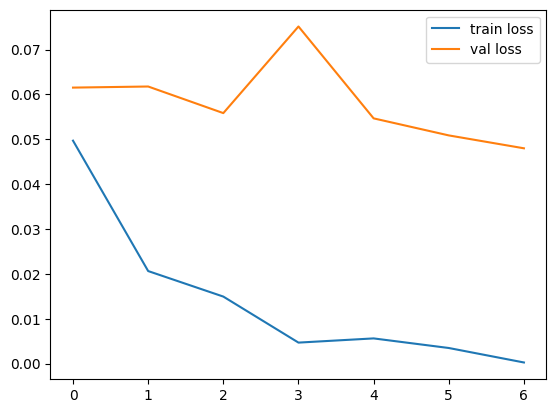

In [59]:
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.legend()
plt.show()

In [60]:
## model evaluation

model.evaluate(X_test, y_test)

58/58 ━━━━━━━━━━━━━━━━━━━━ 7s 120ms/step - accuracy: 0.9795 - loss: 0.0971


[0.047991055995225906, 0.9885182976722717]

58/58 ━━━━━━━━━━━━━━━━━━━━ 9s 145ms/step


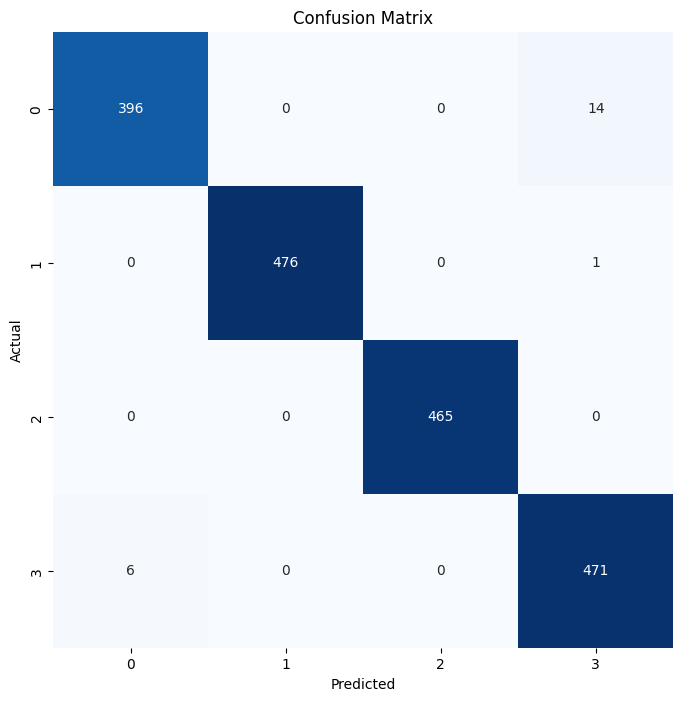

In [61]:
predictions = np.argmax(model.predict(X_test), axis=-1)
cm = confusion_matrix(y_test, predictions)

plt.figure(figsize=(8, 8))
sns.heatmap(cm, annot=True, fmt='d', vmin=0, cbar=False, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [62]:
# Generate classification report
class_labels = list(['cercospora', 'common rust', 'healthy', 'northern leaf blight'])
print(classification_report(y_test, predictions, target_names=class_labels))

                      precision    recall  f1-score   support

          cercospora       0.99      0.97      0.98       410
         common rust       1.00      1.00      1.00       477
             healthy       1.00      1.00      1.00       465
northern leaf blight       0.97      0.99      0.98       477

            accuracy                           0.99      1829
           macro avg       0.99      0.99      0.99      1829
        weighted avg       0.99      0.99      0.99      1829



In [63]:
model.save('final_model.keras')